In [17]:
import numpy as np
import scipy
from sklearn.datasets import make_circles
from sklearn.decomposition import KernelPCA
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import kernel_pca as kpca # python file of own implementation of kernel PCA
from sklearn.metrics import mean_squared_error

In [18]:
X, y = make_circles(n_samples=1_000, factor=0.3, noise=0.05, random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=0)

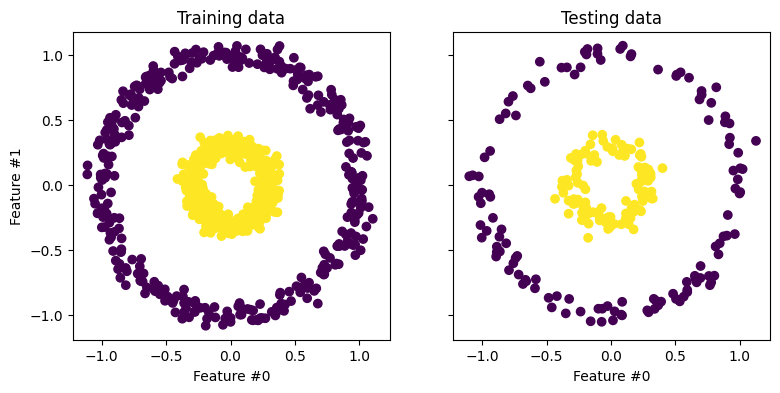

In [19]:
_, (train_ax, test_ax) = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(9, 4))

train_ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train)
train_ax.set_ylabel("Feature #1")
train_ax.set_xlabel("Feature #0")
train_ax.set_title("Training data")

test_ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test)
test_ax.set_xlabel("Feature #0")
_ = test_ax.set_title("Testing data")

# Own implementation

In [20]:
X_transformed_kernel_pca, eigenvectors, eigenvalues = kpca.kernel_PCA(X_train, X_test, n_components=None, kernel='rbf', gamma=10, mode='transform', scaled=False)
X_recon_kernel_pca, X_recon_kernel_pca_err = kpca.kernel_PCA(X_train, X_test, n_components=None, kernel='rbf', gamma=10, mode='recon', alpha=0.1, scaled=False)



 Own rbf kpca implementation
rbf kernel, mse err = 0.011763334350910197


# Compare to the results taken from sklearn example
https://scikit-learn.org/stable/auto_examples/decomposition/plot_kernel_pca.html#sphx-glr-auto-examples-decomposition-plot-kernel-pca-py

In [21]:
kernel_pca = KernelPCA(
    n_components=None, kernel="rbf", gamma=10, eigen_solver='dense', fit_inverse_transform=True, alpha=0.1)
X_kernel_pca_sklearn = kernel_pca.fit(X_train).transform(X_test)
X_recon_kernel_pca_sklearn = kernel_pca.inverse_transform(X_kernel_pca_sklearn)

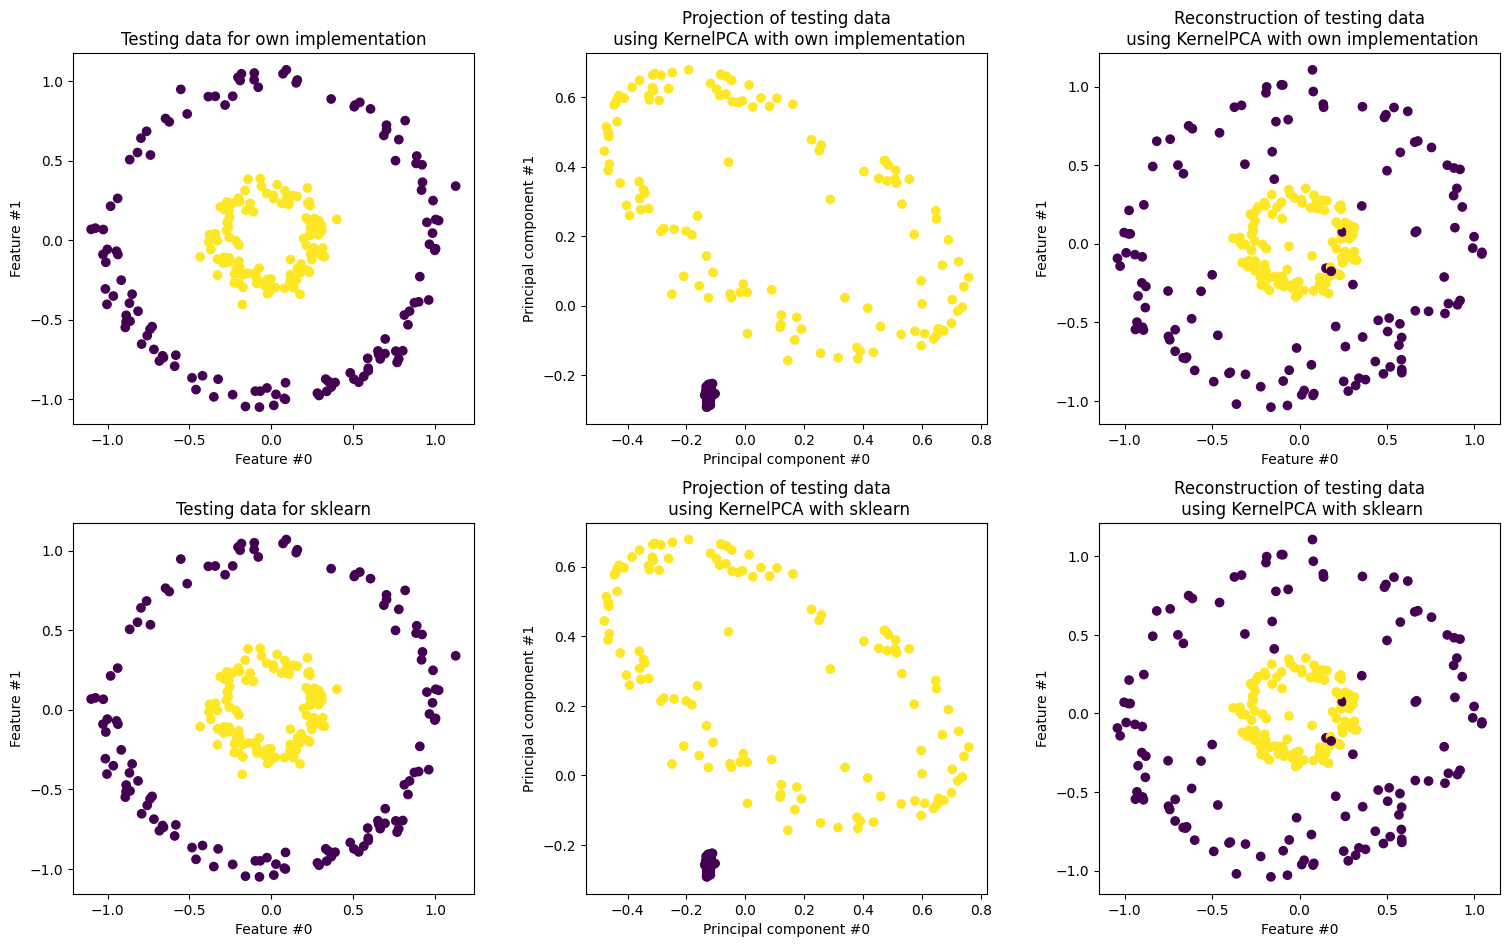

In [22]:
fig, ((orig_data_ax, kernel_pca_proj_ax, kernel_pca_recon_ax), (orig_data_ax_sklearn, kernel_pca_proj_ax_sklearn, kernel_pca_recon_ax_sklearn)) = plt.subplots(nrows=2,
    ncols=3, figsize=(15, 9)
)

fig.tight_layout(h_pad=5, w_pad=5)

orig_data_ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test)
orig_data_ax.set_ylabel("Feature #1")
orig_data_ax.set_xlabel("Feature #0")
orig_data_ax.set_title("Testing data for own implementation")

kernel_pca_proj_ax.scatter(X_transformed_kernel_pca[:, 0], X_transformed_kernel_pca[:, 1], c=y_test)
kernel_pca_proj_ax.set_ylabel("Principal component #1")
kernel_pca_proj_ax.set_xlabel("Principal component #0")
_ = kernel_pca_proj_ax.set_title("Projection of testing data\n using KernelPCA with own implementation")

kernel_pca_recon_ax.scatter(X_recon_kernel_pca[:, 0], X_recon_kernel_pca[:, 1], c=y_test)
kernel_pca_recon_ax.set_ylabel("Feature #1")
kernel_pca_recon_ax.set_xlabel("Feature #0")
_ = kernel_pca_recon_ax.set_title("Reconstruction of testing data\n using KernelPCA with own implementation")

orig_data_ax_sklearn.scatter(X_test[:, 0], X_test[:, 1], c=y_test)
orig_data_ax_sklearn.set_ylabel("Feature #1")
orig_data_ax_sklearn.set_xlabel("Feature #0")
orig_data_ax_sklearn.set_title("Testing data for sklearn")

kernel_pca_proj_ax_sklearn.scatter(X_kernel_pca_sklearn[:, 0], X_kernel_pca_sklearn[:, 1], c=y_test)
kernel_pca_proj_ax_sklearn.set_ylabel("Principal component #1")
kernel_pca_proj_ax_sklearn.set_xlabel("Principal component #0")
_ = kernel_pca_proj_ax_sklearn.set_title("Projection of testing data\n using KernelPCA with sklearn")

kernel_pca_recon_ax_sklearn.scatter(X_recon_kernel_pca_sklearn[:, 0], X_recon_kernel_pca_sklearn[:, 1], c=y_test)
kernel_pca_recon_ax_sklearn.set_ylabel("Feature #1")
kernel_pca_recon_ax_sklearn.set_xlabel("Feature #0")
_ = kernel_pca_recon_ax_sklearn.set_title("Reconstruction of testing data\n using KernelPCA with sklearn")

# Results reproduced perfectly! :D

In [23]:
print(f"Own implementation\n{eigenvectors}")
print(f"sklearn\n{kernel_pca.eigenvectors_}")

Own implementation
[[-0.01342917 -0.03042237 -0.01549663 ... -0.         -0.
   0.        ]
 [ 0.08369597  0.00560315  0.01514663 ... -0.00590524 -0.01639696
  -0.01231157]
 [ 0.05540546 -0.0120412   0.05936189 ...  0.00883146  0.00352819
  -0.019962  ]
 ...
 [ 0.04246709 -0.01753123  0.05499112 ...  0.00712595  0.0142801
  -0.01275347]
 [-0.01435269 -0.02794657 -0.01315284 ...  0.0046077  -0.02148564
  -0.01185784]
 [-0.0144879  -0.02851109 -0.01610421 ... -0.0010564  -0.00079252
  -0.00175155]]
sklearn
[[-1.34291652e-02 -3.04223737e-02 -1.54966288e-02 ...  4.46355034e-02
  -1.64047728e-02 -1.58099591e-02]
 [ 8.36959670e-02  5.60315467e-03  1.51466321e-02 ...  2.66508777e-02
  -2.23595268e-05 -2.97256567e-02]
 [ 5.54054568e-02 -1.20412004e-02  5.93618869e-02 ... -2.37475363e-02
   8.90251622e-03  6.38238263e-03]
 ...
 [ 4.24670950e-02 -1.75312252e-02  5.49911155e-02 ...  8.27787652e-02
  -5.77694839e-03  4.36884185e-02]
 [-1.43526907e-02 -2.79465733e-02 -1.31528429e-02 ...  1.38378692

# Reproduce unified notebook result

## iris

In [21]:
from sklearn.datasets import load_iris, make_swiss_roll, fetch_lfw_people
k=2 # no. of components

iris = load_iris()
X = iris.data # predictor
y = iris.target #response
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=0)

In [22]:
X_recon_kernel_pca, X_recon_kernel_pca_err = kpca.kernel_PCA(X_train, X_test, n_components=k, kernel='rbf', gamma=0.0433, mode='recon', alpha=1.0)
X_recon_kernel_pca_err

0.04562387536597172

# swiss roll

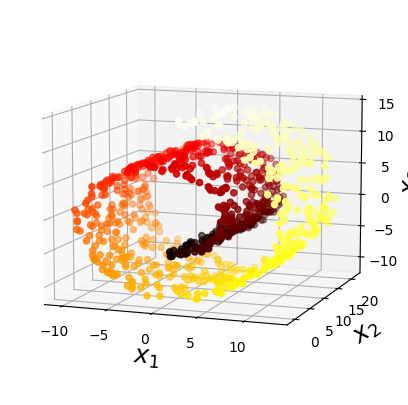

In [23]:
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)
X_train, X_test = train_test_split(X, random_state=0)

axes = [-11.5, 14, -2, 23, -12, 15]

fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=t, cmap=plt.cm.hot)
ax.view_init(10, -70)
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

plt.show()

In [24]:
X_recon_kernel_pca, X_recon_kernel_pca_err = kpca.kernel_PCA(X_train, X_test, n_components=k, kernel='rbf', gamma=0.0433, mode='recon', alpha=1.0)
X_recon_kernel_pca_err

0.04901403520495142

# lfw

In [25]:
lfw_people = fetch_lfw_people(min_faces_per_person=100)
n_samples, h, w = lfw_people.images.shape
X = lfw_people.data
n_features = X.shape[1]
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=0)

In [26]:
X_recon_kernel_pca, X_recon_kernel_pca_err = kpca.kernel_PCA(X_train, X_test, n_components=k, kernel='rbf', gamma=0.0433, mode='recon', alpha=1.0)
X_recon_kernel_pca_err

0.027781419069593548